https://bab2min.tistory.com/552

In [1]:
import networkx
import re
 
class RawSentence:
    def __init__(self, textIter):
        if type(textIter) == str: self.textIter = textIter.split('\n')
        else: self.textIter = textIter
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: continue
                yield s
 
class RawSentenceReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: continue
                yield s
 
class RawTagger:
    def __init__(self, textIter, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Komoran
            self.tagger = Komoran()
        if type(textIter) == str: self.textIter = textIter.split('\n')
        else: self.textIter = textIter
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)
 
class RawTaggerReader:
    def __init__(self, filepath, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Komoran
            self.tagger = Komoran()
        self.filepath = filepath
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)
 
class TextRank:
    def __init__(self, **kargs):
        self.graph = None
        self.window = kargs.get('window', 5)
        self.coef = kargs.get('coef', 1.0)
        self.threshold = kargs.get('threshold', 0.005)
        self.dictCount = {}
        self.dictBiCount = {}
        self.dictNear = {}
        self.nTotal = 0
 
 
    def load(self, sentenceIter, wordFilter = None):
        def insertPair(a, b):
            if a > b: a, b = b, a
            elif a == b: return
            self.dictBiCount[a, b] = self.dictBiCount.get((a, b), 0) + 1
 
        def insertNearPair(a, b):
            self.dictNear[a, b] = self.dictNear.get((a, b), 0) + 1
 
        for sent in sentenceIter:
            for i, word in enumerate(sent):
                if wordFilter and not wordFilter(word): continue
                self.dictCount[word] = self.dictCount.get(word, 0) + 1
                self.nTotal += 1
                if i - 1 >= 0 and (not wordFilter or wordFilter(sent[i-1])): insertNearPair(sent[i-1], word)
                if i + 1 < len(sent) and (not wordFilter or wordFilter(sent[i+1])): insertNearPair(word, sent[i+1])
                for j in range(i+1, min(i+self.window+1, len(sent))):
                    if wordFilter and not wordFilter(sent[j]): continue
                    if sent[j] != word: insertPair(word, sent[j])
 
    def loadSents(self, sentenceIter, tokenizer = None):
        import math
        def similarity(a, b):
            n = len(a.intersection(b))
            return n / float(len(a) + len(b) - n) / (math.log(len(a)+1) * math.log(len(b)+1))
 
        if not tokenizer: rgxSplitter = re.compile('[\\s.,:;-?!()"\']+')
        sentSet = []
        for sent in filter(None, sentenceIter):
            if type(sent) == str:
                if tokenizer: s = set(filter(None, tokenizer(sent)))
                else: s = set(filter(None, rgxSplitter.split(sent)))
            else: s = set(sent)
            if len(s) < 2: continue
            self.dictCount[len(self.dictCount)] = sent
            sentSet.append(s)
 
        for i in range(len(self.dictCount)):
            for j in range(i+1, len(self.dictCount)):
                s = similarity(sentSet[i], sentSet[j])
                if s < self.threshold: continue
                self.dictBiCount[i, j] = s
 
    def getPMI(self, a, b):
        import math
        co = self.dictNear.get((a, b), 0)
        if not co: return None
        return math.log(float(co) * self.nTotal / self.dictCount[a] / self.dictCount[b])
 
    def getI(self, a):
        import math
        if a not in self.dictCount: return None
        return math.log(self.nTotal / self.dictCount[a])
 
    def build(self):
        self.graph = networkx.Graph()
        self.graph.add_nodes_from(self.dictCount.keys())
        for (a, b), n in self.dictBiCount.items():
            self.graph.add_edge(a, b, weight=n*self.coef + (1-self.coef))
 
    def rank(self):
        return networkx.pagerank(self.graph, weight='weight')
 
    def extract(self, ratio = 0.1):
        ranks = self.rank()
        cand = sorted(ranks, key=ranks.get, reverse=True)[:int(len(ranks) * ratio)]
        pairness = {}
        startOf = {}
        tuples = {}
        for k in cand:
            tuples[(k,)] = self.getI(k) * ranks[k]
            for l in cand:
                if k == l: continue
                pmi = self.getPMI(k, l)
                if pmi: pairness[k, l] = pmi
 
        for (k, l) in sorted(pairness, key=pairness.get, reverse=True):
            print(k[0], l[0], pairness[k, l])
            if k not in startOf: startOf[k] = (k, l)
 
        for (k, l), v in pairness.items():
            pmis = v
            rs = ranks[k] * ranks[l]
            path = (k, l)
            tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
            last = l
            while last in startOf and len(path) < 7:
                if last in path: break
                pmis += pairness[startOf[last]]
                last = startOf[last][1]
                rs *= ranks[last]
                path += (last,)
                tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
 
        used = set()
        both = {}
        for k in sorted(tuples, key=tuples.get, reverse=True):
            if used.intersection(set(k)): continue
            both[k] = tuples[k]
            for w in k: used.add(w)
 
        #for k in cand:
        #    if k not in used or True: both[k] = ranks[k] * self.getI(k)
 
        return both
 
    def summarize(self, ratio = 0.333):
        r = self.rank()
        ks = sorted(r, key=r.get, reverse=True)[:int(len(r)*ratio)]
        return ' '.join(map(lambda k:self.dictCount[k], sorted(ks)))

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
df = pd.read_csv("../data/news_data.csv")
df.shape

(180000, 6)

In [4]:
tr = TextRank()
print('Load...')
from konlpy.tag import Komoran
tagger = Komoran()
stopword = set([('있', 'VV'), ('하', 'VV'), ('되', 'VV') ])
tr.loadSents(RawSentenceReader('test2.txt'), lambda sent: filter(lambda x:x not in stopword and x[1] in ('NNG', 'NNP', 'VV', 'VA'), tagger.pos(sent)))
print('Build...')
tr.build()
ranks = tr.rank()
for k in sorted(ranks, key=ranks.get, reverse=True)[:100]:
    print("\t".join([str(k), str(ranks[k]), str(tr.dictCount[k])]))

Load...
Build...
12	0.08380489257648999	민주당은 지난 16일 윤리감찰단을 구성하면서 김 의원 의혹에 대한 기초 조사에 들어갔다.
4	0.08054005764056803	감찰단 최기상 단장은 김 의원에 대한 공직선거법 위반 및 재산 허위 신고 의혹 등에 대한 조사를 개시했으나 김 의원이 이에 대해 성실히 협조하지 않음에 따라 이낙연 대표에게 김 의원에 대한 제명을 요청했다.
7	0.07639009961255862	이에 따라 비례대표인 김 의원은 민주당 최고위의 제명에 따라 당적을 상실하고 무소속 국회의원 신분이 됐다.
3	0.07337743764290626	이번 징계는 전날 본격 가동된 당 윤리감찰단의 요청에 따라 이뤄졌다.
2	0.07155112306605993	최 수석대변인은 "김 의원은 당의 부동산 정책 취지에 부합하지 않는 부동산 과다 보유 등으로 당의 품위를 훼손했다"며 "최고위는 비상 징계 및 제명 필요성에 이의 없이 동의했다"고 말했다.
15	0.06997412999369776	국민의힘 윤희석 대변인은 구두 논평에서 "국민을 기만한 김 의원의 행태가 단순히 제명 조치만으로 면죄부를 받을 수는 없을 것"이라면서 "민주당 당적만 없어질 뿐 의원직은 유지돼 꼬리 자르기라는 의심을 지울 수 없다"고 비판했다.
9	0.06937900522698656	최 의원은 브리핑 후 기자들과 만나 '당에서 탈당을 요청한 적이 없느냐'는 질문에 "탈당 의사가 없었던 것으로 안다"고 말했다.
13	0.06630863529088075	애초 감찰단은 조사 후 징계가 필요하다고 판단할 경우 윤리심판원으로 넘길 예정이었으나 이날 비상 징계를 이낙연 대표에게 요청했다.
8	0.062210329150337265	다만 자진해서 탈당한 것이 아니기 때문에 의원직 신분은 유지된다.
16	0.053225970664267847	정의당 조혜민 대변인도 논평에서 "의원직이 유지되는 만큼 김 의원이 마땅한 책임을 지는 결과라고 할 수 없다"며 "김 의원은 추한 모습으

In [5]:
print(tr.summarize(0.2))

감찰단 최기상 단장은 김 의원에 대한 공직선거법 위반 및 재산 허위 신고 의혹 등에 대한 조사를 개시했으나 김 의원이 이에 대해 성실히 협조하지 않음에 따라 이낙연 대표에게 김 의원에 대한 제명을 요청했다. 이에 따라 비례대표인 김 의원은 민주당 최고위의 제명에 따라 당적을 상실하고 무소속 국회의원 신분이 됐다. 민주당은 지난 16일 윤리감찰단을 구성하면서 김 의원 의혹에 대한 기초 조사에 들어갔다.


In [6]:
tr = TextRank(window=5, coef=1)
print('Load...')
stopword = set([('있', 'VV'), ('하', 'VV'), ('되', 'VV'), ('없', 'VV') ])
tr.load(RawTaggerReader('test2.txt'), lambda w: w not in stopword and (w[1] in ('NNG', 'NNP', 'VV', 'VA')))
print('Build...')
tr.build()
kw = tr.extract(0.1)
for k in sorted(kw, key=kw.get, reverse=True):
    print("%s\t%g" % (k, kw[k]))

Load...
Build...
감찰 단 4.848900370910689
비상 징계 4.666578814116735
윤리 감찰 4.155753190350744
당 윤리 3.9734316335567894
김 의원 3.7502880822425797
단 최 3.0571409016826343
의원 의혹 2.65167579357447
최 의원 1.9585286130145247
(('김', 'NNP'), ('의원', 'NNG'))	0.24133
(('당', 'NNG'), ('윤리', 'NNG'))	0.132985
(('감찰', 'NNG'), ('단', 'NNG'))	0.132581
(('비상', 'NNP'), ('징계', 'NNG'))	0.131848
(('따르', 'VV'),)	0.0635969
(('대하', 'VV'),)	0.0626313
(('제명', 'NNP'),)	0.0580167
(('대변인', 'NNP'),)	0.0571305
(('없', 'VA'),)	0.0522888
(('최', 'NNP'),)	0.0519646
(('의혹', 'NNG'),)	0.0496053
(('대표', 'NNG'),)	0.0473481
(('주택', 'NNG'),)	0.0429416


============================================================

https://blog.theeluwin.kr/post/146188165713/summariz3

In [7]:
from konlpy.tag import Kkma

kkma = Kkma()

In [8]:
from konlpy.tag import Twitter

twitter = Twitter()
twitter.nouns("안녕하세요? 명사를 써야하는데 뭐가 좋을까요. ")

/home/eunbinpark/miniconda3/envs/da/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['명사', '뭐']

In [9]:
from collections import Counter

bow1 = Counter(twitter.nouns("나는 지금 유퀴즈를 보고 있다."))
bow2 = Counter(twitter.nouns("유퀴즈에 나형석 피디가 나오고 있다"))
bow1, bow2

(Counter({'나': 1, '지금': 1, '유': 1, '퀴즈': 1, '보고': 1}),
 Counter({'유': 1, '퀴즈': 1, '나': 1, '형석': 1, '피디': 1}))

In [10]:
j_index = sum((bow1 & bow2).values()) / sum((bow1 | bow2).values())
j_index

0.42857142857142855

In [11]:
class Sentence:

    @staticmethod
    def co_occurence(sentence1, sentence2):
        p = sum((sentence1.bow & sentence2.bow).values())
        q = sum((sentence1.bow | sentence2.bow).values())
        return p / q if q else 0

    def __init__(self, text, index=0):
        self.index = index
        self.text = text
        self.nouns = twitter.nouns(self.text)
        self.bow = Counter(self.nouns)

    def __eq__(self, another):
        return hasattr(another, 'index') and self.index == another.index

    def __hash__(self):
        return self.index

In [12]:
import re

def xplit(*delimiters):
    return lambda value: re.split('|'.join([re.escape(delimiter) for delimiter in delimiters]), value)

def get_sentences(text):
    candidates = xplit('. ', '? ', '! ', '\n', '.\n')(text.strip())
    sentences = []
    index = 0
    for candidate in candidates:
        candidate = candidate.strip()
        if len(candidate):
            sentences.append(Sentence(candidate, index))
            index += 1
    return sentences

In [13]:
def build_graph(sentences):
    graph = networkx.Graph()
    graph.add_nodes_from(sentences)
    pairs = list(itertools.combinations(sentences, 2))
    for eins, zwei in pairs:
        graph.add_edge(eins, zwei, weight=Sentence.co_occurence(eins, zwei))
    return graph

In [24]:
test = get_sentences(df['contents'].iloc[0])
[i.text for i in test]

['이낙연, 윤리감찰단 비상징계 요청에 긴급 최고위 소집해 결단',
 '김홍걸, 당적 상실해 무소속으로…野, 의원직 사퇴요구하며 제명결정 비판',
 '질의하는 김홍걸 의원',
 '[연합뉴스 자료사진]',
 '(서울=연합뉴스) 김동호 이동환 홍규빈 기자 = 더불어민주당은 18일 재산 신고 누락 의혹이 제기된 김대중 전 대통령의 삼남 김홍걸 의원을 제명했다',
 '이낙연 대표가 이날 오후 5시에 긴급 소집한 최고위에서 당헌·당규상의 비상 징계 규정에 따라 만장일치로 이같이 결정했다고 최인호 수석대변인이 브리핑을 통해 밝혔다',
 '최 수석대변인은 "김 의원은 당의 부동산 정책 취지에 부합하지 않는 부동산 과다 보유 등으로 당의 품위를 훼손했다"며 "최고위는 비상 징계 및 제명 필요성에 이의 없이 동의했다"고 말했다',
 '이번 징계는 전날 본격 가동된 당 윤리감찰단의 요청에 따라 이뤄졌다',
 '감찰단 최기상 단장은 김 의원에 대한 공직선거법 위반 및 재산 허위 신고 의혹 등에 대한 조사를 개시했으나 김 의원이 이에 대해 성실히 협조하지 않음에 따라 이낙연 대표에게 김 의원에 대한 제명을 요청했다',
 '최 수석대변인은 "감찰단이 여러 가지 소명이나 본인 주장을 들어보려고 했으나 성실히 응할 의사가 없다는 것을 확인했다"면서 "이 대표는 최기상 단장의 보고를 받고 즉시 긴급 최고위원회의를 소집하게 됐다"고 말했다',
 '최인호 수석대변인',
 '[연합뉴스 자료사진]',
 '비상 징계의 경우 당 윤리위원회 심사 절차를 거치지 않고 즉시 발효된다',
 '이에 따라 비례대표인 김 의원은 민주당 최고위의 제명에 따라 당적을 상실하고 무소속 국회의원 신분이 됐다',
 '다만 자진해서 탈당한 것이 아니기 때문에 의원직 신분은 유지된다',
 '최 의원은 브리핑 후 기자들과 만나 \'당에서 탈당을 요청한 적이 없느냐\'는 질문에 "탈당 의사가 없었던 것으로 안다"고 말했다',
 '앞서 총선 때 3주택을 신고한 김 의원은 당의 다주택 처분 방침에 따라 강남 아파트를 정리했다고 밝

In [14]:
sentences = get_sentences(df['contents'].iloc[0])
sentences = [i for i in get_sentences(df['contents'].iloc[0])][4:-4]

In [16]:
import itertools
graph = build_graph(sentences)
graph

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

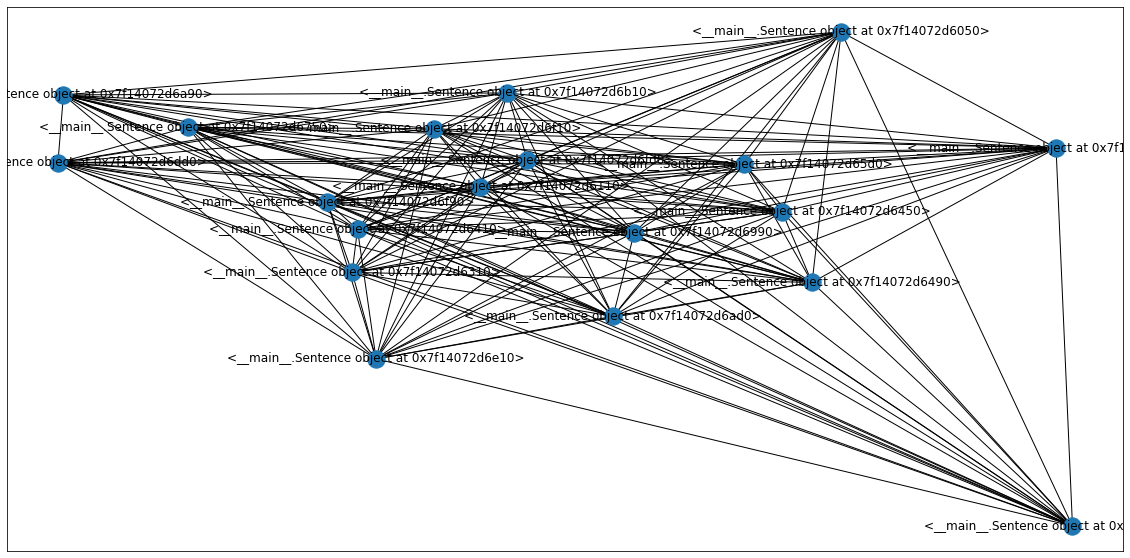

In [18]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(graph)

In [19]:
pagerank = networkx.pagerank(graph, weight='weight')

reordered = sorted(pagerank, key=pagerank.get, reverse=True)
reordered

In [23]:
[sentence.text for sentence in reordered[:3]]

['최 수석대변인은 "김 의원은 당의 부동산 정책 취지에 부합하지 않는 부동산 과다 보유 등으로 당의 품위를 훼손했다"며 "최고위는 비상 징계 및 제명 필요성에 이의 없이 동의했다"고 말했다',
 '감찰단 최기상 단장은 김 의원에 대한 공직선거법 위반 및 재산 허위 신고 의혹 등에 대한 조사를 개시했으나 김 의원이 이에 대해 성실히 협조하지 않음에 따라 이낙연 대표에게 김 의원에 대한 제명을 요청했다',
 '국민의힘 윤희석 대변인은 구두 논평에서 "국민을 기만한 김 의원의 행태가 단순히 제명 조치만으로 면죄부를 받을 수는 없을 것"이라면서 "민주당 당적만 없어질 뿐 의원직은 유지돼 꼬리 자르기라는 의심을 지울 수 없다"고 비판했다']

================================================

https://github.com/fingeredman/text-mining-for-practice

In [25]:
from teanaps.text_analysis import DocumentSummarizer

In [89]:
f = open("test3.txt", "r", encoding="utf-8")
f.read()

'이낙연, 윤리감찰단 비상징계 요청에 긴급 최고위 소집해 결단\n김홍걸, 당적 상실해 무소속으로…野, 의원직 사퇴요구하며 제명결정 비판\n\n\n질의하는 김홍걸 의원\n[연합뉴스 자료사진]\n\n\n(서울=연합뉴스) 김동호 이동환 홍규빈 기자 = 더불어민주당은 18일 재산 신고 누락 의혹이 제기된 김대중 전 대통령의 삼남 김홍걸 의원을 제명했다.\n\n이낙연 대표가 이날 오후 5시에 긴급 소집한 최고위에서 당헌·당규상의 비상 징계 규정에 따라 만장일치로 이같이 결정했다고 최인호 수석대변인이 브리핑을 통해 밝혔다.\n\n최 수석대변인은 "김 의원은 당의 부동산 정책 취지에 부합하지 않는 부동산 과다 보유 등으로 당의 품위를 훼손했다"며 "최고위는 비상 징계 및 제명 필요성에 이의 없이 동의했다"고 말했다.\n\n이번 징계는 전날 본격 가동된 당 윤리감찰단의 요청에 따라 이뤄졌다.\n\n감찰단 최기상 단장은 김 의원에 대한 공직선거법 위반 및 재산 허위 신고 의혹 등에 대한 조사를 개시했으나 김 의원이 이에 대해 성실히 협조하지 않음에 따라 이낙연 대표에게 김 의원에 대한 제명을 요청했다.\n\n최 수석대변인은 "감찰단이 여러 가지 소명이나 본인 주장을 들어보려고 했으나 성실히 응할 의사가 없다는 것을 확인했다"면서 "이 대표는 최기상 단장의 보고를 받고 즉시 긴급 최고위원회의를 소집하게 됐다"고 말했다.\n\n최인호 수석대변인\n[연합뉴스 자료사진]\n\n\n비상 징계의 경우 당 윤리위원회 심사 절차를 거치지 않고 즉시 발효된다.\n\n이에 따라 비례대표인 김 의원은 민주당 최고위의 제명에 따라 당적을 상실하고 무소속 국회의원 신분이 됐다.\n\n다만 자진해서 탈당한 것이 아니기 때문에 의원직 신분은 유지된다.\n\n최 의원은 브리핑 후 기자들과 만나 \'당에서 탈당을 요청한 적이 없느냐\'는 질문에 "탈당 의사가 없었던 것으로 안다"고 말했다.\n\n앞서 총선 때 3주택을 신고한 김 의원은 당의 다주택 처분 방침에 따라 강남 아파트를 정리했다고 밝혔으나 차남에

In [90]:
DOCUMENT_PATH = "test3.txt"

ds = DocumentSummarizer()
ds.set_document(DOCUMENT_PATH)

In [91]:
SUMMARIZER_TYPE = "lsa"

MAX_SENTENCES = 3
ds.summarize(SUMMARIZER_TYPE, MAX_SENTENCES)

In [92]:
ds.get_result()

['최 수석대변인은 "감찰단이 여러 가지 소명이나 본인 주장을 들어보려고 했으나 성실히 응할 의사가 없다는 것을 확인했다"면서 "이 대표는 최기상 단장의 보고를 받고 즉시 긴급 최고위원회의를 소집하게 됐다"고 말했다.',
 '앞서 총선 때 3주택을 신고한 김 의원은 당의 다주택 처분 방침에 따라 강남 아파트를 정리했다고 밝혔으나 차남에게 증여했으며 이 과정에서 세입자 전세금을 한 번에 4억원 올린 사실이 지난달 말 알려지면서 논란이 됐다.',
 '국민의힘 윤희석 대변인은 구두 논평에서 "국민을 기만한 김 의원의 행태가 단순히 제명 조치만으로 면죄부를 받을 수는 없을 것"이라면서 "민주당 당적만 없어질 뿐 의원직은 유지돼 꼬리 자르기라는 의심을 지울 수 없다"고 비판했다.']